In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15667964555972754159
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16230681538453370609
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15271259365628205843
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7791005419826530014
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '/content/drive/My Drive/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = '/content/drive/My Drive/maps/maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

KeyboardInterrupt: ignored

Loaded:  (4000, 256, 256, 3) (4000, 256, 256, 3)


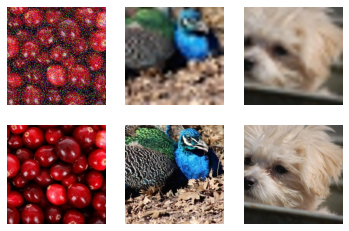

In [ ]:
from numpy import load
from matplotlib import pyplot
data = load('/content/drive/My Drive/comGAN3/CC_DATA.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image])
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g


def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

def define_generator(image_shape=(256,256,3)
  init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

SyntaxError: ignored

In [ ]:
def define_gan(g_model, d_model, image_shape):
	d_model.trainable = False
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model,d_model,gan_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	filename1 = '/content/drive/My Drive/comGAN3/plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	filename2 = '/content/drive/My Drive/comGAN3/gmodel_%06d.h5' % (step+1)
	g_model.save_weights(filename2)
	filename3 = '/content/drive/My Drive/comGAN3/dmodel_%06d.h5' % (step+1)
	d_model.save_weights(filename3)
	filename4 = '/content/drive/My Drive/comGAN3/ganmodel_%06d.h5' % (step+1)
	gan_model.save_weights(filename4)
	filename5 = '/content/drive/My Drive/comGAN3/model_%06d.h5' % (step+1)
	g_model.save(filename5)
	print('>Saved: %s, %s, %s and %s' % (filename1, filename2, filename3, filename4))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=8):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 5) == 0:
			summarize_performance(i, g_model, d_model, gan_model, dataset)

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.models import load_model

In [ ]:
dataset = load_real_samples('/content/drive/My Drive/comGAN3/CC_DATA.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)
# train model
#train(d_model, g_model, gan_model, dataset)
# load model
#12.5+22.5k  IT Over
d_model.load_weights('/content/drive/My Drive/comGAN3/dmodel_022500.h5')
gan_model.load_weights('/content/drive/My Drive/comGAN3/ganmodel_022500.h5')
g_model.load_weights('/content/drive/My Drive/comGAN3/gmodel_022500.h5')
train(d_model, g_model, gan_model, dataset)

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

[X1, X2] = load_real_samples('/content/drive/My Drive/comGAN3/test1_data.npz')
print('Loaded', X1.shape, X2.shape)
model = load_model('/content/drive/My Drive/comGAN3/model_050000.h5')

Loaded (9, 256, 256, 3) (9, 256, 256, 3)


In [ ]:
def plot_images(images):
	filename = '/content/drive/My Drive/comGAN3/VAE_GAN_recon.jpg'
	#images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	rows = 3 # defining no. of rows in figure
	cols = 3  # defining no. of colums in figure
	cell_size = 1.5
	f = pyplot.figure(figsize=(cell_size*cols,cell_size*rows))
	images = (images + 1) / 2.0
	titles = ['Source']
	for i in range(len(images)):
		pyplot.subplot(3, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		#pyplot.title(titles[i])
	pyplot.savefig(filename,bbox_inches='tight')
	pyplot.show()


In [ ]:
def plot_images1(src_img):
	filename = '/content/drive/My Drive/comGAN3/savedImage2.jpg'
	#images = vstack((src_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	for i in range(len(images)):
		pyplot.subplot(1,1 , 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		#pyplot.title(titles[i])
	pyplot.savefig(filename)
	pyplot.show()

In [ ]:
def convert(X1):
  X1 = (X1 * 127.5) + 127.5
  return(X1)

In [ ]:
[X1, X2] = data
print(X1)

arr_0


In [ ]:
src_image, tar_image = X1[0], X2[0]
gen_image = model.predict(src_image)
plot_images(gen_image)

IndexError: ignored

In [ ]:
src_image, tar_image = X1[0:15], X2[0:15]
gen_image = model.predict(src_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

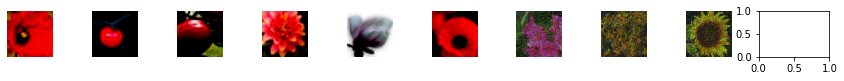

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*3,cols, (3*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(src_image[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*3,cols,((3*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(tar_image[i*cols + j]) 
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows*3,cols,((3*i+2)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(gen_image[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("/content/drive/My Drive/DAE/test_results_cifar10_X.png")

plt.show()

In [ ]:
print(gen_image)

[[[[ 1.39679313e-01  1.10640712e-01 -3.46696138e-01]
   [ 1.36426792e-01  8.80990773e-02 -4.97090399e-01]
   [ 1.32419318e-01  8.52450281e-02 -4.72297043e-01]
   ...
   [ 1.89687878e-01  1.13245375e-01 -4.70531046e-01]
   [ 1.84612140e-01  8.93596411e-02 -5.11272907e-01]
   [ 1.22500755e-01  3.68015952e-02 -4.22927082e-01]]

  [[ 1.57418489e-01  1.09970763e-01 -4.55973297e-01]
   [ 1.71982035e-01  7.86282644e-02 -5.11630714e-01]
   [ 1.67276725e-01  9.22816098e-02 -4.87864673e-01]
   ...
   [ 2.28136539e-01  1.19052082e-01 -4.85060990e-01]
   [ 2.19897836e-01  1.10671312e-01 -5.40811241e-01]
   [ 1.75635740e-01  8.02580118e-02 -5.23813367e-01]]

  [[ 1.26549274e-01  8.83110315e-02 -4.65159923e-01]
   [ 1.62132546e-01  7.65592903e-02 -4.84210908e-01]
   [ 1.56947225e-01  9.61770117e-02 -4.63755280e-01]
   ...
   [ 2.44549796e-01  1.29579648e-01 -4.51768994e-01]
   [ 2.30790868e-01  1.08707637e-01 -5.06899953e-01]
   [ 1.82363704e-01  9.75097567e-02 -4.74815518e-01]]

  ...

  [[ 4.16925